## Compare emissions and concentration driven SSP585 simulations

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")  # we should remove this at some point soon :)

### Import CMIP6 output

In [2]:
import intake

Here I'm pointing to the catalog on Glade

In [3]:
catalog = intake.open_esm_datastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json")
catalog.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,PMIP,NCAR,CESM2,midPliocene-eoi400,r1i1p1f1,Ofx,sftof,gn,NaN,v20200110,NaN,/glade/collections/cmip/CMIP6/PMIP/NCAR/CESM2/...
1,PMIP,NCAR,CESM2,midPliocene-eoi400,r1i1p1f1,Ofx,areacello,gn,NaN,v20200110,NaN,/glade/collections/cmip/CMIP6/PMIP/NCAR/CESM2/...
2,PMIP,NCAR,CESM2,midPliocene-eoi400,r1i1p1f1,Ofx,deptho,gn,NaN,v20200110,NaN,/glade/collections/cmip/CMIP6/PMIP/NCAR/CESM2/...
3,PMIP,NCAR,CESM2,midPliocene-eoi400,r1i1p1f1,Ofx,volcello,gn,NaN,v20200110,NaN,/glade/collections/cmip/CMIP6/PMIP/NCAR/CESM2/...
4,PMIP,NCAR,CESM2,midPliocene-eoi400,r1i1p1f1,CFmon,tnta,gn,NaN,v20200110,105101-110012,/glade/collections/cmip/CMIP6/PMIP/NCAR/CESM2/...


Search for the experiments/variables, then futher refine by models (source_id) and ensemble members (member_id)

In [4]:
test_sr = catalog.search(experiment_id=['esm-ssp585'], variable_id='nbp')

In [5]:
test_sr.unique('source_id')

{'source_id': {'count': 2, 'values': ['CESM2', 'CanESM5']}}

Looks like the catalog still only has two models (CESM2 and CanESM5) for the esm-ssp858 experiment (as of 1/16/20)

In [6]:
table_id = 'Lmon'
sr_nbp = catalog.search(experiment_id=['esm-ssp585','ssp585'], variable_id='nbp', 
                        source_id=['CanESM5', 'CESM2'], table_id=table_id,
                        member_id = ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'])


# TODO: work out catalog search logic for determining what source_ids have members in all experiment_ids

In [7]:
sr_nbp.unique('source_id')['source_id']['values']

['CESM2', 'CanESM5']

In [8]:
sr_nbp.unique('member_id')['member_id']['values']

['r2i1p1f1', 'r1i1p1f1', 'r3i1p1f1']

In [9]:
sr_nbp.unique('grid_label')

{'grid_label': {'count': 1, 'values': ['gn']}}

### Get the fixed variables output, only available for historical simulations (gridcell area, landfrac)
Can subset the models and ensemble members

In [10]:
sr_fx_ctrl_vars = catalog.search(table_id = ['fx'], source_id = sr_nbp.unique('source_id')['source_id']['values'], 
                                 member_id = sr_nbp.unique('member_id')['member_id']['values'], 
                                 experiment_id = 'historical', variable_id = ['areacella', 'sftlf'])

In [11]:
sr_fx_ctrl_vars.unique('grid_label')

{'grid_label': {'count': 1, 'values': ['gn']}}

### Convert the searchs to dictionaries

In [12]:
nbp_ds = sr_nbp.to_dataset_dict()


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 4 group(s)


In [13]:
nbp_ds.keys()

dict_keys(['C4MIP.CCCma.CanESM5.esm-ssp585.Lmon.gn', 'C4MIP.NCAR.CESM2.esm-ssp585.Lmon.gn', 'ScenarioMIP.CCCma.CanESM5.ssp585.Lmon.gn', 'ScenarioMIP.NCAR.CESM2.ssp585.Lmon.gn'])

In [14]:
# get a set of models for later (institution_id.source_id)
models = {'.'.join(s.split('.')[1:3]) for s in nbp_ds.keys()}
models

{'CCCma.CanESM5', 'NCAR.CESM2'}

In [15]:
fx_ds = sr_fx_ctrl_vars.to_dataset_dict()


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


In [16]:
fx_ds.keys()

dict_keys(['CMIP.CCCma.CanESM5.historical.fx.gn', 'CMIP.NCAR.CESM2.historical.fx.gn'])

### Weighted annual means

Weight by number of days in each month

In [17]:
def weighted_annual_mean(da):
    mon_day  = xr.DataArray(np.array([31,28,31,30,31,30,31,31,30,31,30,31]), dims=['month'])
    mon_wgt  = mon_day / mon_day.sum()
    return (da.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

In [26]:
SEC_PER_YEAR = 365 * 24 * 3600

In [27]:
mon_wgts = np.array([31,28,31,30,31,30,31,31,30,31,30,31])

In [28]:
import esmlab

In [29]:
test_nbp_amean = esmlab.core.resample(nbp_ds['C4MIP.CCCma.CanESM5.esm-ssp585.Lmon.gn']['nbp'],freq='mon',weights=mon_wgts) * SEC_PER_YEAR

AttributeError: 'DataArray' object has no attribute 'esmlab'

In [18]:
SEC_PER_YEAR = 365 * 24 * 3600

def calc_nbp_timeseries(nbp, grid_info):
    '''
    Calculate a timeseries of global Net Biome Production (NBP)
    
    Parameters
    ----------
    nbp : xarray.DataArray
        Array of NBP data, units 'kg m-2 s-1'
    grid_info : xarray.Dataset
        Dataset including cell areas (areacella, units m^2) and land fractions (sftlf)
    
    Returns
    -------
    ann_glob : xarray.DataArray
        Global sum of terrestrial NBP, weighted by grid cell area
    '''
    
    # calculate annual means from monthly mean data
    nbp_amean = weighted_annual_mean(nbp) * SEC_PER_YEAR
    nbp_amean.attrs['units'] = 'kgC m^-2 y^-1'

    # calculate global sum
    landUp = grid_info['areacella'] * grid_info['sftlf'] / 100.  # TODO: check that all sftlf are [0, 100], i.e. expressed in %
    mean_wgt = nbp_amean * landUp

    ann_glob = mean_wgt.sum(dim=('lat','lon')) * 1e-12  # sum over lat/lon, convert to Pg/y
    ann_glob.attrs['units'] = 'Pg C y^-1'
   
    return ann_glob


# here's a quick example of how this function can be called
calc_nbp_timeseries(nbp_ds['C4MIP.CCCma.CanESM5.esm-ssp585.Lmon.gn']['nbp'],
                    fx_ds['CMIP.CCCma.CanESM5.historical.fx.gn'])

<xarray.DataArray (member_id: 3, time: 86)>
dask.array<mul, shape=(3, 86), dtype=float64, chunksize=(1, 86), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U8 'r2i1p1f1' 'r1i1p1f1' 'r3i1p1f1'
  * time       (time) object 2015-12-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    units:    Pg C y^-1

In [19]:
def calc_cumulative_timeseries(da):
    '''
    Cumulative Timeseries of Net Biome Production (NBP)
    
    Parameters
    ----------
    da : xarray.DataArray
        Global sum of NBP data, units 'Pg C y^-1'
    
    Returns
    -------
    cda : xarray.DataArray
        Cumulative timeseries of NBP data, units 'Pg C'
    '''
    cda = da.cumsum(dim='time')
    cda.attrs['units'] = 'Pg C'
    return cda

In [20]:
nbp = {}  # we'll put the results from our calc_nbp_timeseries function in this dictionary

for mip, scen in [('C4MIP', 'esm-ssp585'), ('ScenarioMIP', 'ssp585')]:
    for mod in models:
        ds_key = f'{mip}.{mod}.{scen}.{table_id}.gn'
        grid_key = f'CMIP.{mod}.historical.fx.gn'
        
        out_key = ds_key.replace('.Lmon.gn', '')
        
        da = nbp_ds[ds_key]['nbp']
        grid_info = fx_ds[grid_key]

        # QA/QC
        if 'CESM' in ds_key:
            da['lat'] = grid_info['lat']
        # TODO: maybe try --> da = da.reindex_like(grid_info, method='nearest')
        
        nbp[out_key] = calc_nbp_timeseries(da, grid_info)

In [21]:
# calculate the ensemble mean
# use resample to align time coordinates
ens_mean_nbp = {}
for key, da in nbp.items():
    mcount = da.sizes['member_id']  # count of ensemble members
    ens_mean_nbp[key + f' (n={mcount})'] = da.mean(dim='member_id', keep_attrs=True).resample(time='AS').mean(keep_attrs=True)

In [22]:
# combine all the members into 1 DataArray
members = xr.DataArray(list(ens_mean_nbp.keys()), dims='members', name='members')
da = xr.concat(ens_mean_nbp.values(), dim=members)

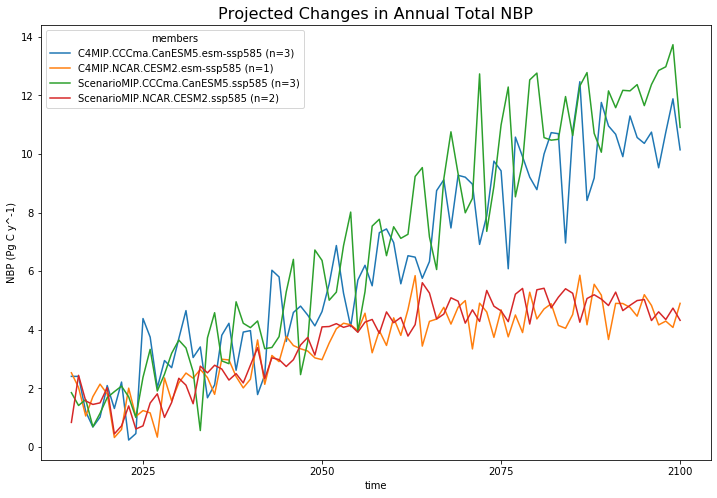

In [23]:
# fig 1 - using built-in xarray plotting
fig = plt.figure(figsize=(12, 8))
da.sel(time=slice('2015', '2100')).plot.line(x='time')
plt.title('Projected Changes in Annual Total NBP', fontdict={'size':16})
plt.ylabel('NBP'+' (' + da.attrs['units'] +')');
# TODO: get ride of "members" legend title? Or replace with something more meaningful

In [24]:
# calculate the cumulative time series
da_cumulative = calc_cumulative_timeseries(da)

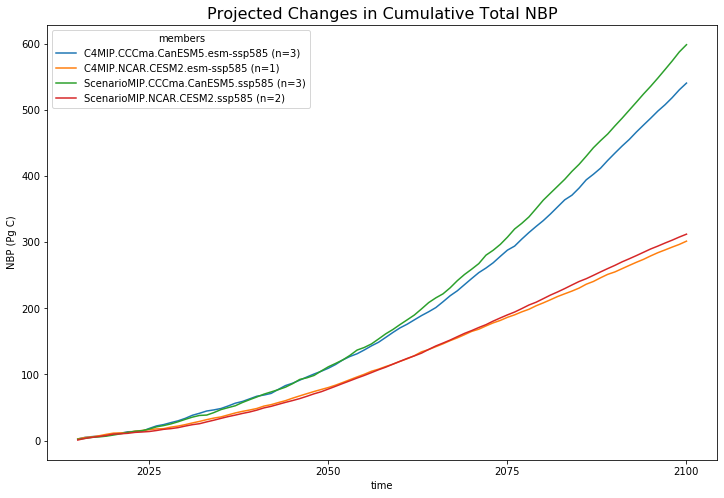

In [25]:
# fig 2
fig = plt.figure(figsize=(12, 8))
da_cumulative.sel(time=slice('2015', '2100')).plot.line(x='time')
plt.title('Projected Changes in Cumulative Total NBP', fontdict={'size':16})
plt.ylabel('NBP'+' (' + da_cumulative.attrs['units'] +')');